In [1]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayushpattiwar","key":"0528b921a4e9d9c2da41dd72cdfef52d"}'}

In [2]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import warnings
warnings.filterwarnings("ignore")
import gc

from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor

In [ ]:
! pip install optuna
import optuna

     |████████████████████████████████| 286kB 5.6MB/s 
     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 163kB 28.5MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 112kB 20.9MB/s 
     |████████████████████████████████| 133kB 21.9MB/s 
     |████████████████████████████████| 481kB 27.1MB/s 
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=a6b1a49fd101b8067420362b30bed2c7553c7c69a116359c039a18f786700fef
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=e28d042b068e45b8ddc6e364618efb4344bad8f0b59eef3edb42a624a3e5544a
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 sha

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
import lightgbm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR

from sklearn.model_selection import KFold
from scipy.stats import randint as sp_randint
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
import pickle
from tqdm import tqdm

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# https://www.kaggle.com/c/champs-scalar-coupling/discussion/96655
def reduce_mem_usage(df, verbose=True):

  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)    
  end_mem = df.memory_usage().sum() / 1024**2
  if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df

In [11]:
train = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CASE_STUDY_1/train3'))
test = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CASE_STUDY_1/test3'))

Mem. usage decreased to 89.73 Mb (75.6% reduction)
Mem. usage decreased to 54.82 Mb (75.5% reduction)


In [12]:
train.head()

,Unnamed: 0,card_id,feature_1,feature_2,feature_3,target,outliers,quarter,total_time,start_month,start_year,dayofweek,total_time_feature1,total_time_feature2,total_time_feature3,total_time_feature1_ratio,total_time_feature2_ratio,total_time_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var,transactions_purchased_on_weekend_sum,transactions_purchased_on_weekend_mean,transactions_purchased_on_weekday_sum,transactions_purchased_on_weekday_mean,transactions_dayofweek_nunique,transactions_dayofweek_sum,transactions_dayofweek_mean,transactions_dayofweek_max,transactions_hour_of_purchase_nunique,transactions_hour_of_purchase_mean,transactions_hour_of_purchase_min,transactions_hour_of_purchase_max,transactions_Minute_of_purchase_nunique,transactions_Minute_of_purchase_mean,transactions_Minute_of_purchase_min,transactions_Minute_of_purchase_max,transactions_Second_of_purchase_nunique,...,new_transactions_purchase_date_diff,new_transactions_purchase_date_average,new_transactions_purchase_date_uptonow,new_transactions_purchase_date_uptomin,transactions_purchase_date_difference,new_transactions_purchase_date_difference,Avg_purchase,new_Avg_purchase,last_purchase_from_now,new_last_purchase_from_now,first_purchase_from_now,new_first_purchase_from_now,card_id_total,card_id_ratio,total_purchase_amount_max,total_purchase_amount_min,total_purchase_amount_mean,total_purchase_amount_sum,total_purchase_amount_ratio,total_installments_max,total_installments_mean,total_installments_sum,total_installments_ratio,total_month_lag_max,total_month_lag_min,total_month_lag_mean,total_month_lag_sum,total_month_lag_ratio,total_duration_max,total_duration_min,total_duration_mean,total_month_diff_max,total_month_diff_mean,total_month_diff_min,total_amount_month_ratio_max,total_amount_month_ratio_min,total_amount_month_ratio_mean,customer_rating,new_customer_rating,customer_rating_ratio
0,0,C_ID_92a2005557,0.013145,0.008751,0.011429,-0.820312,0,2,1324,6,2017,3,17.406250,11.585938,15.132812,0.000010,0.000007,0.000009,0.033325,0.011108,0.013145,0.008751,0.002214,90.0,0.346191,170.0,0.653809,7,835.0,3.210938,6,23,13.312500,0,23,60,28.171875,0,59,60,...,54.0,2.347656,992.0,1047.0,20977988.0,4742309.0,80684.562500,206187.343750,1055,992.0,1298,1047.0,283.0,0.088440,0.923828,-1.463867,-1.218750,-180.2500,0.079285,1.099609,0.213867,31.890625,0.077698,2.0,-7.0,-2.433594,-983.0,-0.033417,32.312500,-51.78125,-42.68750,71.0,70.0625,70.0,0.026398,-0.041809,-0.034760,-1237.715210,-8.703125,142.233261
1,1,C_ID_3d0044924f,0.010712,0.011383,0.010284,0.392822,0,1,1475,1,2017,6,15.796875,16.796875,15.164062,0.000007,0.000008,0.000007,0.032379,0.010796,0.011383,0.010284,0.000556,132.0,0.377197,218.0,0.623047,7,1177.0,3.363281,6,24,14.718750,0,23,60,29.140625,0,59,59,...,56.0,9.335938,1022.0,1078.0,33717688.0,4887632.0,96336.250000,814605.312500,1079,1022.0,1469,1078.0,356.0,0.017136,0.518066,-1.481445,-1.337891,-218.5000,0.020340,14.000000,2.632812,577.000000,0.010506,2.0,-11.0,-3.531250,-1752.0,-0.005112,18.640625,-53.90625,-48.21875,73.0,72.1250,71.0,0.014389,-0.041504,-0.037109,-2075.675537,-0.726074,2859.406006
2,2,C_ID_d639edf6cd,0.010612,0.008751,0.010284,0.687988,0,3,1628,8,2016,0,17.265625,14.250000,16.734375,0.000006,0.000005,0.000006,0.029648,0.009880,0.010612,0.008751,0.000992,11.0,0.255859,32.0,0.744141,7,142.0,3.302734,6,14,17.906250,8,23,33,25.671875,0,59,31,...,0.0,0.000000,992.0,992.0,35635624.0,0.0,828735.437500,0.000000,1052,992.0,1465,992.0,44.0,0.023254,-0.846191,-1.429688,-1.378906,-29.8750,0.024002,0.199951,0.199951,4.402344,0.023239,2.0,-11.0,-6.605469,-368.0,-0.005405,-29.609375,-50.68750,-48.28125,71.0,70.0625,70.0,-0.024170,-0.040863,-0.039337,-35.768433,-0.020004,1787.922729
3,3,C_ID_186d6a6901,0.010712,0.014168,0.010284,0.142456,0,3,1232,9,2017,4,13.195312,17.453125,12.671875,0.000009,0.000012,0.000008,0.035156,0.011719,0.014168,0.010284,0.002129,11.0,0.142822,66.0,0.856934,7,215.0,2.792969,6,16,14.445312,0,23,46,29.765625,0,59

In [13]:
test.head()

,Unnamed: 0,card_id,feature_1,feature_2,feature_3,quarter,total_time,start_month,start_year,dayofweek,total_time_feature1,total_time_feature2,total_time_feature3,total_time_feature1_ratio,total_time_feature2_ratio,total_time_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var,transactions_purchased_on_weekend_sum,transactions_purchased_on_weekend_mean,transactions_purchased_on_weekday_sum,transactions_purchased_on_weekday_mean,transactions_dayofweek_nunique,transactions_dayofweek_sum,transactions_dayofweek_mean,transactions_dayofweek_max,transactions_hour_of_purchase_nunique,transactions_hour_of_purchase_mean,transactions_hour_of_purchase_min,transactions_hour_of_purchase_max,transactions_Minute_of_purchase_nunique,transactions_Minute_of_purchase_mean,transactions_Minute_of_purchase_min,transactions_Minute_of_purchase_max,transactions_Second_of_purchase_nunique,transactions_Second_of_purchase_mean,transactions_Second_of_purchase_min,...,new_transactions_purchase_date_diff,new_transactions_purchase_date_average,new_transactions_purchase_date_uptonow,new_transactions_purchase_date_uptomin,transactions_purchase_date_difference,new_transactions_purchase_date_difference,Avg_purchase,new_Avg_purchase,last_purchase_from_now,new_last_purchase_from_now,first_purchase_from_now,new_first_purchase_from_now,card_id_total,card_id_ratio,total_purchase_amount_max,total_purchase_amount_min,total_purchase_amount_mean,total_purchase_amount_sum,total_purchase_amount_ratio,total_installments_max,total_installments_mean,total_installments_sum,total_installments_ratio,total_month_lag_max,total_month_lag_min,total_month_lag_mean,total_month_lag_sum,total_month_lag_ratio,total_duration_max,total_duration_min,total_duration_mean,total_month_diff_max,total_month_diff_mean,total_month_diff_min,total_amount_month_ratio_max,total_amount_month_ratio_min,total_amount_month_ratio_mean,customer_rating,new_customer_rating,customer_rating_ratio
0,0,C_ID_0ab67a22ab,0.010483,0.014168,0.011429,2,1385,4,2017,5,14.515625,19.625000,15.828125,0.000008,0.000010,0.000008,0.036072,0.012024,0.014168,0.010483,0.001915,12.0,0.176514,56.0,0.823730,7,190.0,2.794922,6,17,14.367188,0,23,38,30.578125,0,55,43,27.890625,0,...,25.0,8.335938,1051.0,1077.0,23179380.0,2193863.0,3.408732e+05,731287.68750,1113,1051.0,1381,1077.0,71.0,0.044128,-0.147583,-1.466797,-1.191406,-42.500000,0.043640,15.0,3.742188,146.0,0.035461,2.0,-6.0,-1.632812,-241.0,-0.024292,-5.226562,-55.00000,-44.12500,75.0,74.125,74.0,-0.004158,-0.039490,-0.032166,-74.626831,-0.144165,517.850098
1,1,C_ID_130fd0cbdd,0.010612,0.014168,0.010284,1,1475,1,2017,6,15.648438,20.890625,15.164062,0.000007,0.000010,0.000007,0.035065,0.011688,0.014168,0.010284,0.002153,17.0,0.217896,61.0,0.782227,7,229.0,2.935547,6,18,14.421875,0,23,45,31.203125,0,59,40,31.578125,1,...,48.0,5.332031,1000.0,1049.0,34667912.0,4167689.0,4.444604e+05,463076.56250,1061,1000.0,1462,1049.0,87.0,0.115356,-0.187500,-1.472656,-1.291016,-55.062500,0.121033,7.0,2.287109,94.0,0.132568,2.0,-12.0,-8.968750,-799.0,-0.016006,-6.562500,-52.25000,-45.25000,71.0,70.125,70.0,-0.005356,-0.042053,-0.036804,-108.999451,-1.528320,71.297646
2,2,C_ID_b709037bc5,0.013145,0.011383,0.011429,3,1263,8,2017,1,16.609375,14.382812,14.429688,0.000010,0.000009,0.000009,0.035950,0.011986,0.013145,0.011383,0.001004,0.0,0.000000,13.0,1.000000,4,34.0,2.615234,4,7,17.000000,13,20,13,31.765625,2,57,13,33.531250,3,...,11.0,5.500000,1039.0,1050.0,13924886.0,1030753.0,1.071145e+06,515376.50000,1077,1039.0,1238,1050.0,15.0,0.153809,2.125000,-1.261719,0.315674,3.115234,0.061218,23.0,12.117188,97.0,0.127930,1.0,-5.0,-1.077148,-25.0,-0.074097,75.250000,-44.12500,11.50000,71.0,70.500,70.0,0.059967,-0.036041,0.008652,1.090346,0.010124,107.707222
3,3,C_ID_d27d835a9f,0.010612,0.011383,0.010284,4,1141,12,2017,4,12.109375,12.992188,11.734375,0.000009,0.000010,0.000009,0.032288,0.010757,0.011383,0.010284,0.000566,7.0,0.269287,19.0,0.730957,7,64.0,2.460938,6,9,17.921875,8,22,22,30.0

In [14]:
outliers=train['outliers']
target=train['target']
card_id=test['card_id']

In [15]:
train_cols = [c for c in train.columns if c not in ['card_id','target','outliers']]

Linear Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.2)

In [ ]:
model = LinearRegression()
model.fit(X_train[train_cols], y_train)

yhat=model.predict(X_test[train_cols])
test_rmse = np.sqrt(mean_squared_error(y_test, yhat))
print('test_rmse is : {}'.format(test_rmse))

test_rmse is : 3.7851559803719113


Sgd Regressor

In [ ]:
# hyper parameter tuned using grid search cv
model = SGDRegressor(alpha=10)
model.fit(X_train[train_cols], y_train)

yhat=model.predict(X_test[train_cols])
test_rmse = np.sqrt(mean_squared_error(y_test, yhat))
print('test_rmse is : {}'.format(test_rmse))

test_rmse is : 3.7295214999652155e+21


Random Forest Regression

In [ ]:
# taking too much time too run
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train[train_cols])
y_pred_test = model.predict(X_test[train_cols])

train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))

print("Train RMSE: {:2.5f}".format(train_rmse))
print("Test RMSE: {:2.5f}".format(test_rmse))

Hyperparameter Tuning using Optuna

In [ ]:
# https://github.com/optuna/optuna/blob/master/examples/lightgbm_simple.py
# https://github.com/niranjanbsubramanian/kaggle/blob/master/Elo%20Merchant%20Category%20Recommendataion.ipynb

def objective(trial):
    
    lgbm_train = lightgbm.Dataset(train[train_cols], target, free_raw_data=False)

    params = {
              'objective': 'regression', 'metric': 'rmse',
              'verbosity': -1,  "learning_rate": 0.01,
              'device': 'cpu',  'seed': 326,
              'boosting_type': 'gbdt', 'n_jobs': 8,
              'num_leaves': trial.suggest_int('num_leaves', 16, 64), 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.001, 1),
              'subsample': trial.suggest_uniform('subsample', 0.001, 1), 'max_depth': trial.suggest_int('max_depth', 1, 12),
              'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 10), 'reg_lambda': trial.suggest_uniform('reg_lambda', 0, 10),
              'min_split_gain': trial.suggest_uniform('min_split_gain', 0, 10), 'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 45),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 16, 64)
              }


    folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=326)

    clf = lightgbm.cv(params=params, train_set=lgbm_train, metrics=['rmse'], nfold=3, \
                      folds=folds.split(train[train_cols], outliers.values), \
                      num_boost_round=10000, early_stopping_rounds=200, verbose_eval=2000, seed=47)
    gc.collect()
    return clf['rmse-mean'][-1]

if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective, n_trials=35);gc.collect()
    print('Number of finished trials: {}'.format(len(study.trials)))
    print('Best trial:')
    trial = study.best_trial;gc.collect()
    print('  Value: {}'.format(trial.value))
    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

[I 2021-01-22 09:32:41,451] A new study created in memory with name: no-name-74ce23b1-a35b-4e82-b283-a734b75d74a5
[I 2021-01-22 09:35:37,221] Trial 0 finished with value: 3.6588622512601106 and parameters: {'num_leaves': 46, 'colsample_bytree': 0.49159574255137833, 'subsample': 0.0087193433220101, 'max_depth': 5, 'reg_alpha': 9.881610540017983, 'reg_lambda': 6.576856524160123, 'min_split_gain': 4.8695438587525395, 'min_child_weight': 29.092294235585815, 'min_data_in_leaf': 60}. Best is trial 0 with value: 3.6588622512601106.
[I 2021-01-22 09:38:04,839] Trial 1 finished with value: 3.66050827705252 and parameters: {'num_leaves': 48, 'colsample_bytree': 0.08932909922654794, 'subsample': 0.3380162823038536, 'max_depth': 7, 'reg_alpha': 9.788992685039123, 'reg_lambda': 6.956654530808746, 'min_split_gain': 5.301662452656962, 'min_child_weight': 18.804766982023736, 'min_data_in_leaf': 33}. Best is trial 0 with value: 3.6588622512601106.
[I 2021-01-22 09:41:21,161] Trial 2 finished with value

[2000]	cv_agg's rmse: 3.67127 + 0.00651239
[4000]	cv_agg's rmse: 3.66803 + 0.00679031


[I 2021-01-22 09:45:23,090] Trial 3 finished with value: 3.6679110767810332 and parameters: {'num_leaves': 49, 'colsample_bytree': 0.3952577225029966, 'subsample': 0.5636873458455905, 'max_depth': 3, 'reg_alpha': 8.688603196454741, 'reg_lambda': 7.738338047251002, 'min_split_gain': 6.507662766311916, 'min_child_weight': 39.02291929038754, 'min_data_in_leaf': 23}. Best is trial 2 with value: 3.6578852180179715.


[2000]	cv_agg's rmse: 3.66246 + 0.00638047


[I 2021-01-22 09:47:27,374] Trial 4 finished with value: 3.6614813799591013 and parameters: {'num_leaves': 21, 'colsample_bytree': 0.07893423213516569, 'subsample': 0.4594839444365741, 'max_depth': 9, 'reg_alpha': 4.709266021728808, 'reg_lambda': 0.7461191307630588, 'min_split_gain': 6.798514551693372, 'min_child_weight': 25.127120456137337, 'min_data_in_leaf': 62}. Best is trial 2 with value: 3.6578852180179715.
[I 2021-01-22 09:50:42,357] Trial 5 finished with value: 3.659871586768143 and parameters: {'num_leaves': 40, 'colsample_bytree': 0.6127306617148763, 'subsample': 0.07030704665139931, 'max_depth': 8, 'reg_alpha': 2.190216657743027, 'reg_lambda': 1.5671396191257436, 'min_split_gain': 3.6401326786451973, 'min_child_weight': 1.6769221958319969, 'min_data_in_leaf': 35}. Best is trial 2 with value: 3.6578852180179715.
[I 2021-01-22 09:54:18,370] Trial 6 finished with value: 3.6602660559970537 and parameters: {'num_leaves': 47, 'colsample_bytree': 0.7075539075535372, 'subsample': 0.

[2000]	cv_agg's rmse: 3.67191 + 0.00653077


[I 2021-01-22 10:04:04,679] Trial 9 finished with value: 3.6692474248413447 and parameters: {'num_leaves': 20, 'colsample_bytree': 0.6998009985696713, 'subsample': 0.5393290250945671, 'max_depth': 3, 'reg_alpha': 9.028059433370828, 'reg_lambda': 9.968656263631196, 'min_split_gain': 7.4969514324391415, 'min_child_weight': 36.50245221081773, 'min_data_in_leaf': 57}. Best is trial 2 with value: 3.6578852180179715.
[I 2021-01-22 10:08:56,198] Trial 10 finished with value: 3.6654180094492355 and parameters: {'num_leaves': 63, 'colsample_bytree': 0.9947890829127681, 'subsample': 0.784203104652798, 'max_depth': 12, 'reg_alpha': 7.001038909369862, 'reg_lambda': 4.90155029505204, 'min_split_gain': 0.1429623449448023, 'min_child_weight': 15.589909149472913, 'min_data_in_leaf': 50}. Best is trial 2 with value: 3.6578852180179715.
[I 2021-01-22 10:12:27,496] Trial 11 finished with value: 3.6628617337356038 and parameters: {'num_leaves': 64, 'colsample_bytree': 0.9256998924366568, 'subsample': 0.98

[2000]	cv_agg's rmse: 3.75328 + 0.00310797
[4000]	cv_agg's rmse: 3.74227 + 0.00365534
[6000]	cv_agg's rmse: 3.73667 + 0.00403746
[8000]	cv_agg's rmse: 3.73292 + 0.00434569


[I 2021-01-22 10:16:36,907] Trial 12 finished with value: 3.730346027676033 and parameters: {'num_leaves': 33, 'colsample_bytree': 0.2841561504387337, 'subsample': 0.7996634927028026, 'max_depth': 1, 'reg_alpha': 7.298726453914669, 'reg_lambda': 3.188003990705595, 'min_split_gain': 9.737902487605911, 'min_child_weight': 29.908807492524375, 'min_data_in_leaf': 45}. Best is trial 2 with value: 3.6578852180179715.


[10000]	cv_agg's rmse: 3.73035 + 0.00446003


[I 2021-01-22 10:20:07,794] Trial 13 finished with value: 3.6622808704021406 and parameters: {'num_leaves': 57, 'colsample_bytree': 0.8520977067644468, 'subsample': 0.8050260504801414, 'max_depth': 5, 'reg_alpha': 0.02466223665081113, 'reg_lambda': 5.246893051230594, 'min_split_gain': 8.11051681591049, 'min_child_weight': 43.40684303532787, 'min_data_in_leaf': 43}. Best is trial 2 with value: 3.6578852180179715.


[2000]	cv_agg's rmse: 3.67157 + 0.00622191


[I 2021-01-22 10:24:21,390] Trial 14 finished with value: 3.669099352449328 and parameters: {'num_leaves': 33, 'colsample_bytree': 0.5061442837403505, 'subsample': 0.9256585271139074, 'max_depth': 3, 'reg_alpha': 7.684209376509666, 'reg_lambda': 8.61092586047379, 'min_split_gain': 5.838952544429479, 'min_child_weight': 11.219074655557895, 'min_data_in_leaf': 30}. Best is trial 2 with value: 3.6578852180179715.
[I 2021-01-22 10:27:10,584] Trial 15 finished with value: 3.658568841903323 and parameters: {'num_leaves': 55, 'colsample_bytree': 0.2601762897207716, 'subsample': 0.680777211829654, 'max_depth': 10, 'reg_alpha': 5.809165947772003, 'reg_lambda': 5.926731684346407, 'min_split_gain': 3.4679460457985707, 'min_child_weight': 25.234288055705388, 'min_data_in_leaf': 16}. Best is trial 2 with value: 3.6578852180179715.
[I 2021-01-22 10:29:37,860] Trial 16 finished with value: 3.657123889948426 and parameters: {'num_leaves': 40, 'colsample_bytree': 0.4041932962899831, 'subsample': 0.9941

[2000]	cv_agg's rmse: 3.66025 + 0.0059173


[I 2021-01-22 10:40:17,153] Trial 19 finished with value: 3.660147077625013 and parameters: {'num_leaves': 16, 'colsample_bytree': 0.4242493650106734, 'subsample': 0.16641479654163593, 'max_depth': 8, 'reg_alpha': 0.4552296006037233, 'reg_lambda': 2.694255419905134, 'min_split_gain': 7.302654885278944, 'min_child_weight': 20.563617379333262, 'min_data_in_leaf': 54}. Best is trial 16 with value: 3.657123889948426.
[I 2021-01-22 10:44:35,575] Trial 20 finished with value: 3.6623854506675673 and parameters: {'num_leaves': 26, 'colsample_bytree': 0.7922488364168311, 'subsample': 0.9983328620919418, 'max_depth': 10, 'reg_alpha': 6.054540557926051, 'reg_lambda': 0.006877425340259258, 'min_split_gain': 8.10315898245813, 'min_child_weight': 33.55850692649162, 'min_data_in_leaf': 40}. Best is trial 16 with value: 3.657123889948426.


[2000]	cv_agg's rmse: 3.66074 + 0.0061621


[I 2021-01-22 10:47:15,032] Trial 21 finished with value: 3.660563486652226 and parameters: {'num_leaves': 37, 'colsample_bytree': 0.3459424252220156, 'subsample': 0.8728341037187498, 'max_depth': 4, 'reg_alpha': 9.163567172758087, 'reg_lambda': 3.632712305241681, 'min_split_gain': 6.153386920328523, 'min_child_weight': 25.816983251044004, 'min_data_in_leaf': 36}. Best is trial 16 with value: 3.657123889948426.
[I 2021-01-22 10:49:30,385] Trial 22 finished with value: 3.656999693119321 and parameters: {'num_leaves': 44, 'colsample_bytree': 0.1696581488236113, 'subsample': 0.715822406877161, 'max_depth': 6, 'reg_alpha': 9.914682301044571, 'reg_lambda': 5.90997459764173, 'min_split_gain': 4.630616977085437, 'min_child_weight': 40.07408193575955, 'min_data_in_leaf': 29}. Best is trial 22 with value: 3.656999693119321.
[I 2021-01-22 10:51:47,794] Trial 23 finished with value: 3.6567426820375384 and parameters: {'num_leaves': 53, 'colsample_bytree': 0.17673834076860082, 'subsample': 0.70879

[2000]	cv_agg's rmse: 3.73094 + 0.0026076
[4000]	cv_agg's rmse: 3.71496 + 0.0037236
[6000]	cv_agg's rmse: 3.70836 + 0.00408904


[I 2021-01-22 10:57:34,823] Trial 24 finished with value: 3.707178631806494 and parameters: {'num_leaves': 52, 'colsample_bytree': 0.01103795718381717, 'subsample': 0.6897023166472716, 'max_depth': 6, 'reg_alpha': 8.089392235040991, 'reg_lambda': 5.77372180797206, 'min_split_gain': 2.3998382885514387, 'min_child_weight': 40.3122773246717, 'min_data_in_leaf': 17}. Best is trial 23 with value: 3.6567426820375384.
[I 2021-01-22 10:59:46,019] Trial 25 finished with value: 3.658194557898785 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.17979545569612693, 'subsample': 0.6174351480556433, 'max_depth': 8, 'reg_alpha': 9.991462810285007, 'reg_lambda': 6.248731940126966, 'min_split_gain': 4.522582220838486, 'min_child_weight': 41.617311942241024, 'min_data_in_leaf': 22}. Best is trial 23 with value: 3.6567426820375384.


[2000]	cv_agg's rmse: 3.75419 + 0.00288779
[4000]	cv_agg's rmse: 3.74292 + 0.00348208
[6000]	cv_agg's rmse: 3.73716 + 0.00388464
[8000]	cv_agg's rmse: 3.73327 + 0.00422732


[I 2021-01-22 11:02:34,701] Trial 26 finished with value: 3.7305715572574587 and parameters: {'num_leaves': 52, 'colsample_bytree': 0.15656984999175777, 'subsample': 0.7460979101291462, 'max_depth': 1, 'reg_alpha': 8.499627971492712, 'reg_lambda': 4.2724798884599275, 'min_split_gain': 1.55510556271149, 'min_child_weight': 36.821116557234305, 'min_data_in_leaf': 28}. Best is trial 23 with value: 3.6567426820375384.


[10000]	cv_agg's rmse: 3.73057 + 0.00436985
[2000]	cv_agg's rmse: 3.6626 + 0.00576452


[I 2021-01-22 11:04:34,695] Trial 27 finished with value: 3.6620647984755164 and parameters: {'num_leaves': 36, 'colsample_bytree': 0.1775693814907878, 'subsample': 0.5031751189920107, 'max_depth': 4, 'reg_alpha': 6.595738287051649, 'reg_lambda': 5.6474183979063595, 'min_split_gain': 2.837980801888891, 'min_child_weight': 34.39045456828012, 'min_data_in_leaf': 20}. Best is trial 23 with value: 3.6567426820375384.
[I 2021-01-22 11:06:44,780] Trial 28 finished with value: 3.6599109032944757 and parameters: {'num_leaves': 44, 'colsample_bytree': 0.0874746221336422, 'subsample': 0.4254655709667781, 'max_depth': 6, 'reg_alpha': 4.412921054073396, 'reg_lambda': 5.11879569865546, 'min_split_gain': 4.445146159348458, 'min_child_weight': 44.85667357339324, 'min_data_in_leaf': 31}. Best is trial 23 with value: 3.6567426820375384.


[2000]	cv_agg's rmse: 3.66207 + 0.00693929


[I 2021-01-22 11:09:52,567] Trial 29 finished with value: 3.6618315835280693 and parameters: {'num_leaves': 45, 'colsample_bytree': 0.4520662020898967, 'subsample': 0.8667685856114176, 'max_depth': 4, 'reg_alpha': 9.43556603400069, 'reg_lambda': 6.598833019853035, 'min_split_gain': 5.119465951116682, 'min_child_weight': 27.314755452676263, 'min_data_in_leaf': 26}. Best is trial 23 with value: 3.6567426820375384.


[2000]	cv_agg's rmse: 3.6811 + 0.00468396
[4000]	cv_agg's rmse: 3.67407 + 0.00466606


[I 2021-01-22 11:13:07,787] Trial 30 finished with value: 3.67378370006484 and parameters: {'num_leaves': 51, 'colsample_bytree': 0.02938252645381348, 'subsample': 0.7038068579119108, 'max_depth': 5, 'reg_alpha': 9.994499551349238, 'reg_lambda': 7.718334997380738, 'min_split_gain': 5.341031580742355, 'min_child_weight': 39.787586760415095, 'min_data_in_leaf': 20}. Best is trial 23 with value: 3.6567426820375384.
[I 2021-01-22 11:16:36,787] Trial 31 finished with value: 3.658340517496301 and parameters: {'num_leaves': 60, 'colsample_bytree': 0.6330628580473219, 'subsample': 0.9976998697002234, 'max_depth': 7, 'reg_alpha': 9.476015419067178, 'reg_lambda': 7.329621830117029, 'min_split_gain': 3.3534508461916572, 'min_child_weight': 32.825250149823574, 'min_data_in_leaf': 44}. Best is trial 23 with value: 3.6567426820375384.
[I 2021-01-22 11:19:37,125] Trial 32 finished with value: 3.657126234471047 and parameters: {'num_leaves': 61, 'colsample_bytree': 0.5061192674373116, 'subsample': 0.8

Number of finished trials: 35
Best trial:
  Value: 3.6567426820375384
  Params: 
    num_leaves: 53
    colsample_bytree: 0.17673834076860082
    subsample: 0.7087951348526023
    max_depth: 6
    reg_alpha: 9.908320306141416
    reg_lambda: 6.0071344861003615
    min_split_gain: 4.3475986877999055
    min_child_weight: 39.106365420975735
    min_data_in_leaf: 18


### Training With best params

In [ ]:
# using stratified k-folds with n_splits
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4950)
# list to save predictions
oof3 = np.zeros(len(train))
predictions8 = np.zeros(len(test))
# this data_frame stores the feature importance
feature_importance_df6 = pd.DataFrame()

#creating folds
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, train['outliers'].values)):
    
    print("fold {}".format(fold_))
    # creating fold datasets 
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_cols ], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_cols ], label=target.iloc[val_idx])

    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.7087951348526023,
                'max_depth': 6,
                'top_rate': 0.9064148448434349,
                'num_leaves': 53,
                'min_child_weight': 39.106365420975735,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.908320306141416,
                'colsample_bytree': 0.17673834076860082,
                'min_split_gain': 4.3475986877999055,
                'reg_lambda': 6.0071344861003615,
                'min_data_in_leaf': 18,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    # predictions on cv dataset
    oof3[val_idx] = clf.predict(train.iloc[val_idx][train_cols ], num_iteration=clf.best_iteration)
    
    # calculating feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_cols 
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df6 = pd.concat([feature_importance_df6, fold_importance_df], axis=0)
    
    # predictions on test sets
    predictions8 += clf.predict(test[train_cols], num_iteration=clf.best_iteration) / 10

# calculating rmse on cv
np.sqrt(mean_squared_error(oof3, target))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[926]	training's rmse: 3.47691	valid_1's rmse: 3.66789
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1550]	training's rmse: 3.37689	valid_1's rmse: 3.79797
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1131]	training's rmse: 3.48335	valid_1's rmse: 3.5575
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1111]	training's rmse: 3.45428	valid_1's rmse: 3.6226
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1472]	training's rmse: 3.42632	valid_1's rmse: 3.61497
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1218]	training's rmse: 3.42009	valid_1's rmse: 3.73535
fold 6
Training until validation scor

3.6507806526605098

In [ ]:
submission_name = pd.to_datetime("today")
sub_df4 = pd.DataFrame({"card_id":card_id})
sub_df4["target"] = predictions8
sub_df4.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.621152
1,C_ID_130fd0cbdd,-0.212622
2,C_ID_b709037bc5,-0.835433
3,C_ID_d27d835a9f,-0.103825
4,C_ID_2b5e3df5c2,-1.088865


In [ ]:
sub_df4.to_csv('/content/submission_lGB_repeated_tuned.csv(1)', index=False)
!kaggle competitions submit elo-merchant-category-recommendation -f '/content/submission_lGB_repeated_tuned.csv(1)' -m "model_11"

100% 4.24M/4.24M [00:00<00:00, 14.1MB/s]
Successfully submitted to Elo Merchant Category Recommendation

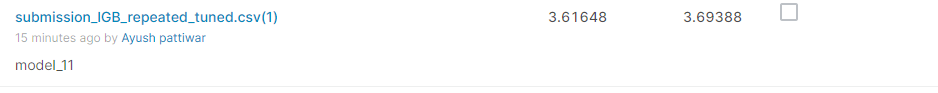

### LightGBM with Stratified k-fold

In [ ]:
# kernel : https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending/output
# using stratified k-folds with n_splits
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=4950)
# list to save predictions
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
# this data_frame stores the feature importance
feature_importance_df = pd.DataFrame()

#creating folds
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, train['outliers'].values)):
    
    print("fold {}".format(fold_))
    # creating fold datasets 
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_cols ], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_cols ], label=target.iloc[val_idx])
    
    # this params is taken from kernel mentioned above
    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.7087951348526023,
                'max_depth': 6,
                'top_rate': 0.9064148448434349,
                'num_leaves': 53,
                'min_child_weight': 39.106365420975735,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.908320306141416,
                'colsample_bytree': 0.17673834076860082,
                'min_split_gain': 4.3475986877999055,
                'reg_lambda': 6.0071344861003615,
                'min_data_in_leaf': 18,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    # predictions on cv dataset
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_cols ], num_iteration=clf.best_iteration)
    
    # calculating feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_cols 
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # predictions on test sets
    predictions += clf.predict(test[train_cols], num_iteration=clf.best_iteration) / folds.n_splits

# calculating rmse on cv
np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2082]	training's rmse: 3.35248	valid_1's rmse: 3.65424
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1527]	training's rmse: 3.41448	valid_1's rmse: 3.64796
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[955]	training's rmse: 3.47412	valid_1's rmse: 3.65986
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1175]	training's rmse: 3.45007	valid_1's rmse: 3.64691
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1227]	training's rmse: 3.44788	valid_1's rmse: 3.65162


3.652122985599067

In [ ]:
# kaggle submission
submission_name = pd.to_datetime("today")
sub_df = pd.DataFrame({"card_id":card_id})
sub_df["target"] = predictions
sub_df.to_csv('/content/submission_lGB_stratified_tuned.csv(1)', index=False)
!kaggle competitions submit elo-merchant-category-recommendation -f '/content/submission_lGB_stratified_tuned.csv(1)' -m "model_12"

100% 4.24M/4.24M [00:00<00:00, 14.1MB/s]
Successfully submitted to Elo Merchant Category Recommendation

In [ ]:
sub_df.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.654845
1,C_ID_130fd0cbdd,-0.252591
2,C_ID_b709037bc5,-0.834280
3,C_ID_d27d835a9f,-0.087706
4,C_ID_2b5e3df5c2,-1.106020


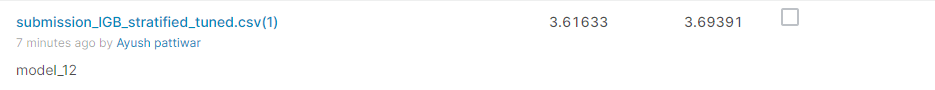

###Combining Using baysian_Ridge

In [ ]:
# https://github.com/RoyMachineLearning/Elo-Merchant-Category-Recommendation/blob/master/ELO%20Goss%20Boosting%20V2.0.ipynb

# stscking the results of stratifed kfold and repeated kfold
train_stack = np.vstack([oof3,oof]).transpose()
test_stack = np.vstack([predictions8, predictions]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=4590)

# intializing list to store results
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):

    # creating dataset with folds
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    # fitting the model
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    # predictions
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5

# printing cv_rmse
np.sqrt(mean_squared_error(target.values, oof_stack))

3.6492487301179954

In [ ]:
# kaggle submission
submission_name = pd.to_datetime("today")
sub_df3 = pd.DataFrame({"card_id":card_id})
sub_df3["target"] = predictions_3
sub_df3.to_csv('/content/submission_baysian_stack_tuned(1).csv', index=False)
!kaggle competitions submit elo-merchant-category-recommendation -f '/content/submission_baysian_stack_tuned(1).csv' -m "model_13"

100% 4.23M/4.23M [00:00<00:00, 14.1MB/s]
Successfully submitted to Elo Merchant Category Recommendation

In [ ]:
sub_df3.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.819021
1,C_ID_130fd0cbdd,-0.220663
2,C_ID_b709037bc5,-0.860736
3,C_ID_d27d835a9f,-0.081273
4,C_ID_2b5e3df5c2,-1.136465


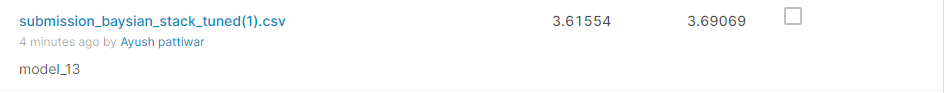

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/CASE_STUDY_1/lgb_baysian1.sav'
pickle.dump(clf_3, open(filename, 'wb'))

### Xgb model

In [ ]:
# hyperparameter tuning using randomsearch
# https://github.com/niranjanbsubramanian/kaggle/blob/master/Elo%20Merchant%20Category%20Recommendataion.ipynb

xgb = xgb.XGBRegressor(learning_rate=0.01, n_estimators=100, objective= 'reg:linear', \
                       eval_metric ='rmse', silent=True, nthread=1, tree_method='gpu_hist')

parameters = {
         'num_boost_round': [10, 25, 50], 'eta': [0.05, 0.1, 0.3],
         'max_depth': [3, 4, 5, 6,], 'subsample':[i/10.0 for i in range(6,10)],
         'colsample_bytree':[i/10.0 for i in range(6,10)], "min_samples_split": sp_randint(2, 11),
         "min_samples_leaf": sp_randint(1, 11), "min_child_weight": range(1,6,2),
         'gamma':[i/10.0 for i in range(0,5)], 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }

random_search = RandomizedSearchCV(xgb, param_distributions=parameters, \
                cv=StratifiedKFold(n_splits=9, random_state=42).split(train[train_cols],outliers.values),\
                n_jobs=-1, n_iter=30, verbose=3)

random_search.fit(train[train_cols], target)

In [ ]:
random_search.best_params_

{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'num_boost_round': 50,
 'reg_alpha': 1e-05,
 'subsample': 0.7}

In [ ]:
# training with best params
xgb_params = {
              'eta': 0.3, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.9, \
              'learning_rate':0.01, 'gamma':0.3, 'min_samples_leaf' : 1, 'min_samples_split': 2, \
              'num_boost_round': 50, 'reg_alpha': 1e-05,'objective': 'reg:linear', 'eval_metric': 'rmse', \
              'silent': True, 'tree_method':'gpu_hist'
              }

# using k_folds
FOLDs = KFold(n_splits=9, shuffle=True, random_state=0)

# intializing list to store results
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))


for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train,outliers.values)):

    # creating xgb datamatrix with folds
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx][train_cols], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx][train_cols], label=target.iloc[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000

    # training and predicting on cv
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, \
                          early_stopping_rounds=200, verbose_eval=200)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][train_cols]), \
                                         ntree_limit=xgb_model.best_ntree_limit+50)
    
    # predicting on test_data
    predictions_xgb = predictions_xgb + xgb_model.predict(xgb.DMatrix(test[train_cols]), \
                            ntree_limit=xgb_model.best_ntree_limit+50) / FOLDs.n_splits

# printing cv_rmse
np.sqrt(mean_squared_error(oof_xgb, target))

xgb 0--------------------------------------------------
[0]	train-rmse:3.9514	valid-rmse:3.91646
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[200]	train-rmse:3.59351	valid-rmse:3.62161
[400]	train-rmse:3.50293	valid-rmse:3.59887
[600]	train-rmse:3.43893	valid-rmse:3.59094
[800]	train-rmse:3.38177	valid-rmse:3.58799
[1000]	train-rmse:3.33188	valid-rmse:3.58635
[1200]	train-rmse:3.28134	valid-rmse:3.58626
[1400]	train-rmse:3.23623	valid-rmse:3.58579
[1600]	train-rmse:3.19108	valid-rmse:3.58525
Stopping. Best iteration:
[1540]	train-rmse:3.20463	valid-rmse:3.5848

xgb 1--------------------------------------------------
[0]	train-rmse:3.94496	valid-rmse:3.96655
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[200]	train-rmse:3.58011	valid-rmse:3.69809
[400]	train-rmse:3.4869	valid-rmse:3.68245

3.657161154388778

In [ ]:
submission_name = pd.to_datetime("today")
sub_df5 = pd.DataFrame({"card_id":card_id})
sub_df5["target"] = predictions_xgb
sub_df5.to_csv('/content/submission_Xgb.csv', index=False)
!kaggle competitions submit elo-merchant-category-recommendation -f '/content/submission_Xgb.csv' -m "model_8"
sub_df5.head()

100% 4.24M/4.24M [00:05<00:00, 884kB/s]
Successfully submitted to Elo Merchant Category Recommendation

,card_id,target
0,C_ID_0ab67a22ab,-4.470792
1,C_ID_130fd0cbdd,-0.301885
2,C_ID_b709037bc5,-0.900795
3,C_ID_d27d835a9f,-0.097475
4,C_ID_2b5e3df5c2,-1.136551


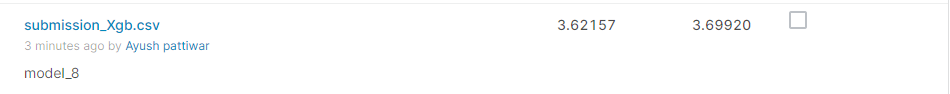

### Custom Ensemble model

**Hyper parameter tuning for no_of_base_learners**

1. Split your whole data into train and test(80-20)
2. Now in the 80% train set, split the train set into D1 and D2.(50-50)
3. Now from this D1 do sampling with replacement to create d1,d2,d3....dk(k samples).
4. Now create 'k' models and train each of these models with each of these k samples.
5. Now pass the D2 set to each of these k models, now you will get k predictions for D2, from each of these models.
6. Now using these k predictions create a new dataset, and for D2, you already know it's corresponding target values, so now you train a meta model with these k predictions.
7. Now for model evaluation, you have can use the 20% data that you have kept as the test set. Pass that test set to each of the base models and you will get 'k' predictions. Now you create a new dataset with these k predictions and pass it to your metamodel and you will get the final prediction. Now using this final prediction as well as the targets for the test set, you can calculate the models performance score.

In [ ]:
# splitting train test in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(train[train_cols], target, test_size = 0.2,random_state=0)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(161533, 236) (161533,)
(40384, 236) (40384,)


In [ ]:
# spliting train further into two equal data_sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X_train, y_train, test_size = 0.5,random_state=0)
print(X1_train.shape,y1_train.shape)
print(X1_test.shape,y1_test.shape)

(80766, 236) (80766,)
(80767, 236) (80767,)


In [ ]:
# stores the results
rmse=[]
# we are trying with 5 different nos of base learners
q=[20,40,60,80,100]

for i in tqdm(q):
  # stores list of models
  learners = []
  for j in range(i):
    length = len(X1_train)
    # selecting columns with replacement
    rows = np.random.randint(0,length,55000)
    # creating samples from first 50% of train data
    new_x = X1_train.iloc[rows]
    new_y = y1_train.iloc[rows]

    # we create a shallow model on created data sample
    regressor = DecisionTreeRegressor(max_depth = 4,criterion='mse')
    regressor.fit(new_x,new_y)

    # append model to list
    learners.append(regressor)

    # create a dataframe to store the result
    reg_data = pd.DataFrame()
    for a,b in enumerate(learners):
      # here we use next 50% percent of train data for predictions and training of metamodel
      predictions = b.predict(X1_test)
      reg_data['reg_{}'.format(a+1)] = predictions

    # fitting the meta model on results obtained from above
    model = LinearRegression()
    model.fit(reg_data, y1_test)

    # create a dataframe to store the result
    df2 = pd.DataFrame()
    for no,reg in enumerate(learners):
      # here we use the 20% test data to get k predictions
      predictions = reg.predict(X_test)
      df2['reg_{}'.format(no+1)] = predictions

    # using our meta model for getting final results
    k=model.predict(df2)
    # calculating rmse score
    score = np.sqrt(mean_squared_error(k, y_test))
  print(score)
  # appending final score in list
  rmse.append(score)

 20%|██        | 1/5 [01:35<06:20, 95.13s/it]

3.6948679117083594


 40%|████      | 2/5 [06:00<07:18, 146.10s/it]

3.690304950712975


 60%|██████    | 3/5 [14:38<08:35, 257.80s/it]

3.700230642569044


 80%|████████  | 4/5 [28:52<07:16, 436.62s/it]

3.694537508250537


100%|██████████| 5/5 [49:38<00:00, 595.73s/it]

3.696497240784261


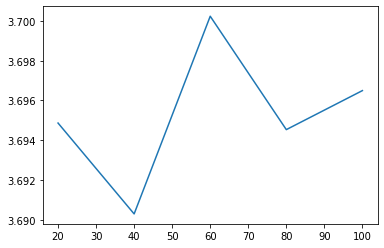

In [ ]:
plt.plot(q, rmse)

Here we can see that using 40 learners gives us least rmse value so we will use this for our whole dataset.

**Now using 40 lerners and training on whole datset**

In [ ]:
learners = []
for j in tqdm(range(40)):
    length = len(train[train_cols])
    rows = np.random.randint(0,length,55000)
    new_x = train[train_cols].iloc[rows]
    new_y = target.iloc[rows]

    regressor = DecisionTreeRegressor(max_depth = 4,criterion='mse')
    regressor.fit(new_x,new_y)

    learners.append(regressor)

    reg_data = pd.DataFrame()
    for a,b in enumerate(learners):
      predictions = b.predict(train[train_cols])
      reg_data['reg_{}'.format(a+1)] = predictions

    model = LinearRegression()
    model.fit(reg_data, target)

    df2 = pd.DataFrame()
    for no,reg in enumerate(learners):
      predictions = reg.predict(test[train_cols])
      df2['reg_{}'.format(no+1)] = predictions

    k=model.predict(df2)

100%|██████████| 40/40 [10:11<00:00, 15.28s/it]


In [ ]:
# making kaggle submission ready
submission_name = pd.to_datetime("today")
sub_df7 = pd.DataFrame({"card_id":card_id})
sub_df7["target"] = k
sub_df7.to_csv('/content/submission_custom.csv', index=False)
!kaggle competitions submit elo-merchant-category-recommendation -f '/content/submission_custom.csv' -m "model_9"

In [ ]:
sub_df7.head()

,card_id,target
0,C_ID_0ab67a22ab,-4.960792
1,C_ID_130fd0cbdd,-0.093485
2,C_ID_b709037bc5,-0.917166
3,C_ID_d27d835a9f,-0.093485
4,C_ID_2b5e3df5c2,-0.851467


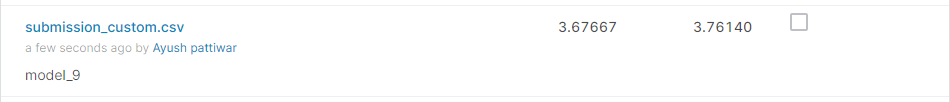

This ensemble model results are not upto the mark.

### Adaboost Model

Adaboost model with linear loss

In [16]:
from sklearn.ensemble import AdaBoostRegressor

In [17]:
# n_estimators ae hyper parameter tuned with gridsearch cv
regr = AdaBoostRegressor(random_state=0, n_estimators=100, loss='linear')
regr.fit(train[train_cols], target)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=0)

In [18]:
k=regr.predict(test[train_cols])

In [19]:
sub_df8 = pd.DataFrame({"card_id":card_id})
sub_df8["target"] = k
sub_df8.head()

,card_id,target
0,C_ID_0ab67a22ab,-14.470339
1,C_ID_130fd0cbdd,-2.145515
2,C_ID_b709037bc5,-9.169068
3,C_ID_d27d835a9f,-0.203268
4,C_ID_2b5e3df5c2,-2.145515


In [25]:
submission_name = pd.to_datetime("today")
sub_df8.to_csv('/content/adaboost.csv', index=False)
!kaggle competitions submit elo-merchant-category-recommendation -f '/content/adaboost.csv' -m "model_14"

100% 4.17M/4.17M [00:00<00:00, 4.53MB/s]
Successfully submitted to Elo Merchant Category Recommendation

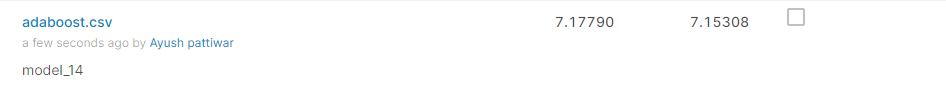

The results are worst I even tried it with squared loss but results are not looking good.

### Mlp Models

Training a shallow mlp with 3 layers

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from sklearn.metrics import mean_squared_error
from keras import backend as Keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [36]:
# https://heartbeat.fritz.ai/how-to-create-a-custom-loss-function-in-keras-637bd312e9ab
def rmse(y_true, y_pred):
        return Keras.sqrt(Keras.mean(Keras.square(y_pred - y_true)))

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(train[train_cols].shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss=rmse, optimizer="adam")

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                7584      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 8,321
Trainable params: 8,289
Non-trainable params: 32
_________________________________________________________________


In [38]:
early_stop = EarlyStopping(monitor='loss',patience=6, verbose=1, mode='auto')
model.fit(train[train_cols], target, batch_size=64, epochs=50, verbose=2, callbacks=[early_stop])

Epoch 1/50
3155/3155 - 6s - loss: 3.3783
Epoch 2/50
3155/3155 - 5s - loss: 3.3651
Epoch 3/50
3155/3155 - 6s - loss: 3.3568
Epoch 4/50
3155/3155 - 5s - loss: 3.3689
Epoch 5/50
3155/3155 - 5s - loss: 3.3632
Epoch 6/50
3155/3155 - 5s - loss: 3.3801
Epoch 7/50
3155/3155 - 5s - loss: 3.3874
Epoch 8/50
3155/3155 - 5s - loss: 3.3654
Epoch 9/50
3155/3155 - 6s - loss: 3.3613
Epoch 00009: early stopping


In [39]:
ypred = model.predict(test[train_cols])

In [40]:
submission_name = pd.to_datetime("today")
sub_df9 = pd.DataFrame({"card_id":card_id})
sub_df9["target"] = ypred
sub_df9.head()

,card_id,target
0,C_ID_0ab67a22ab,-0.084905
1,C_ID_130fd0cbdd,0.359233
2,C_ID_b709037bc5,0.199742
3,C_ID_d27d835a9f,-0.317419
4,C_ID_2b5e3df5c2,0.339378


In [41]:
sub_df9.to_csv('/content/shallow_mlp(1).csv', index=False)
!kaggle competitions submit elo-merchant-category-recommendation -f '/content/shallow_mlp(1).csv' -m "model_15"

100% 3.21M/3.21M [00:01<00:00, 1.96MB/s]
Successfully submitted to Elo Merchant Category Recommendation

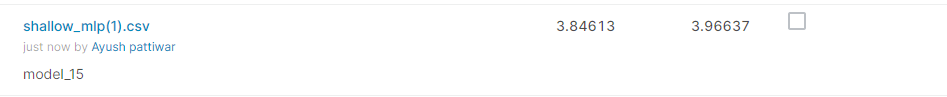

Training a deep mlp with 5 layers and dropouts

In [45]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(train[train_cols].shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss=rmse, optimizer="adam")

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               30336     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)               

In [47]:
early_stop = EarlyStopping(monitor='loss',patience=6, verbose=1, mode='auto')
model.fit(train[train_cols], target, batch_size=64, epochs=50, verbose=2, callbacks=[early_stop])

Epoch 1/50
3155/3155 - 7s - loss: 3.3967
Epoch 2/50
3155/3155 - 6s - loss: 3.3927
Epoch 3/50
3155/3155 - 6s - loss: 3.3788
Epoch 4/50
3155/3155 - 6s - loss: 3.3884
Epoch 5/50
3155/3155 - 6s - loss: 3.3864
Epoch 6/50
3155/3155 - 6s - loss: 3.3787
Epoch 7/50
3155/3155 - 6s - loss: 3.3635
Epoch 8/50
3155/3155 - 6s - loss: 3.3935
Epoch 9/50
3155/3155 - 6s - loss: 3.3718
Epoch 10/50
3155/3155 - 6s - loss: 3.3736
Epoch 11/50
3155/3155 - 6s - loss: 3.3677
Epoch 12/50
3155/3155 - 6s - loss: 3.3770
Epoch 13/50
3155/3155 - 6s - loss: 3.3814
Epoch 00013: early stopping


In [48]:
ypred = model.predict(test[train_cols])

In [49]:
submission_name = pd.to_datetime("today")
sub_df10 = pd.DataFrame({"card_id":card_id})
sub_df10["target"] = ypred
sub_df10.head()

,card_id,target
0,C_ID_0ab67a22ab,-0.087942
1,C_ID_130fd0cbdd,-0.455512
2,C_ID_b709037bc5,-0.062622
3,C_ID_d27d835a9f,-0.300122
4,C_ID_2b5e3df5c2,-0.365675


In [50]:
sub_df10.to_csv('/content/deep_mlp.csv', index=False)
!kaggle competitions submit elo-merchant-category-recommendation -f '/content/deep_mlp.csv' -m "model_16"

100% 3.24M/3.24M [00:01<00:00, 2.49MB/s]
Successfully submitted to Elo Merchant Category Recommendation

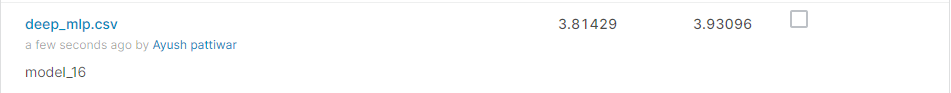

Score improved a bit as compared to shallow mlp but it is still less than our baysian stack classifier.